In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
from os import listdir
import glob

#from skimage.transform import rotate, resize
from skimage import io
import cv2
import tifffile as tiff
import numpy as np
import PIL.Image as Image
from matplotlib import pyplot as plt


In [ ]:
image = Image.open('/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_images/AT-Z-01-32_1x1.tif').convert('L')
image.size

(256, 256)

## Slice with rotate option

In [2]:
import os
from PIL import Image
import cv2
import numpy as np
import tifffile as tiff

import os
from PIL import Image
import numpy as np

def slice_6(input_dir, output_dir, rot=False):
    for image in os.listdir(input_dir):
        img = Image.open(os.path.join(input_dir, image))
        img = np.array(img)  # Converter para matriz NumPy
        img = cv2.resize(img, (681, 512))

        if rot:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

        linha = 1
        coluna = 1
        inicioLinha = 0
        for i in range(256, 513, 256):
            inicioColuna = 0
            for j in range(256, 513, 256):
                if rot:
                    nome = (image.split('.')[0] + f'_{linha}x{coluna}_r.tif')
                else:
                    nome = (image.split('.')[0] + f'_{linha}x{coluna}.tif')

                sliced_image = Image.fromarray(img[inicioLinha:i, inicioColuna:j])
                sliced_image.save(os.path.join(output_dir, nome), format='TIFF')

                coluna += 1
                inicioColuna += j

            linha += 1
            coluna = 1
            inicioLinha += i

        if rot:
            slice_3x1 = Image.fromarray(img[-256:, :256])
            filename1 = (image.split('.')[0] + '_3x1_r.tif')
            slice_3x2 = Image.fromarray(img[-256:, 256:512])
            filename2 = (image.split('.')[0] + '_3x2_r.tif')

            slice_3x1.save(os.path.join(output_dir, filename1), format='TIFF')
            slice_3x2.save(os.path.join(output_dir, filename2), format='TIFF')
        else:
            slice_1x3 = Image.fromarray(img[:256, -256:])
            filename1 = (image.split('.')[0] + '_1x3.tif')
            slice_2x3 = Image.fromarray(img[256:512, -256:])
            filename2 = (image.split('.')[0] + '_2x3.tif')

            slice_1x3.save(os.path.join(output_dir, filename1), format='TIFF')
            slice_2x3.save(os.path.join(output_dir, filename2), format='TIFF')



## Data Augmentation

In [4]:
# Data
input_directory = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Ground_truth/Dados_teste/masks_corrigidas/'
save_directory =  '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_masks_corrigidas/'

# Rodar os dois juntos para ter 6 imagens fariadas e mais 6 rotacionadas
slice_6(input_directory, save_directory)
slice_6(input_directory, save_directory, rot=True)

#slice_6_rotated(input_directory, save_directory)

In [5]:
print(len( os.listdir(save_directory)))

132


In [ ]:
img = cv2.imread('/content/drive/MyDrive/DisciplinaMachineLearning/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/ground_truth/masks/AT-Z-01-32.tif', 0)
img.shape

(1024, 1362)

In [ ]:
print(len( os.listdir(save_directory_im)))

348


 ## Masks Preprocessing


In [ ]:
from skimage.filters.rank import modal
from skimage.morphology import square
from skimage.filters import gaussian
# Importar e criar dataset de masks
file_name_masks = glob.glob("/content/drive/MyDrive/DisciplinaMachineLearning/masks_tif/mask_gimp/*.png")
file_name_masks.sort()

output_path = '/content/drive/MyDrive/DisciplinaMachineLearning/masks_tif/mask_gimp_multiclass/'


for mask in file_name_masks: # para cada imagem no diretorio
    img = cv2.imread(mask, 0) # ler imagem

    # tirar valores mais altos
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > 17: #VALORES DA LISTA FORAM CALCULADOS SEPARADAMENTE
                img[i][j] = 0

    # filtro de moda, para tirar salty noise
    img_gauss = gaussian(img, sigma=.4, preserve_range=True)   # testar
    #img_modal = modal(img, square(3))

    # binarizar (multyiclass) as masks
    thresholds = [1, 4, 8, 12, 15] # bins obtidos por multi-otsu em amostras representativas
    img_multiclass = np.digitize(img_gauss, bins=thresholds)

    # salvar
    path = output_path + mask.split('mask_gimp/')[1]
    cv2.imwrite(path,img_multiclass) # salvar mask

"""    #exibir
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title(mask.split('mask_gimp/')[1])
    plt.imshow(img_multiclass, cmap='Greys')
    plt.subplot(122)
    plt.hist(img_multiclass.ravel(),60,[0,10])
    plt.show()
    print("Labels in the mask are : ", np.unique(img_multiclass))"""


'    #exibir\n    plt.figure(figsize=(20,10))\n    plt.subplot(121)\n    plt.title(mask.split(\'mask_gimp/\')[1])\n    plt.imshow(img_multiclass, cmap=\'Greys\')\n    plt.subplot(122)\n    plt.hist(img_multiclass.ravel(),60,[0,10])\n    plt.show()\n    print("Labels in the mask are : ", np.unique(img_multiclass))'

# Espelhar Horiz. e Vertic.

In [ ]:
import os
from PIL import Image

def espelhar_e_salvar_imagens(caminho_arquivo, pasta_saida):
    imagem = Image.open(caminho_arquivo).convert('L')

    # Cria a pasta de saída se ela não existir
    if not os.path.exists(pasta_saida):
        os.makedirs(pasta_saida)

    imagem_espelhada_horizontal = imagem.transpose(Image.FLIP_LEFT_RIGHT)
    nome_arquivo_horizontal = os.path.join(pasta_saida, "espelho_horizontal.tif")
    imagem_espelhada_horizontal.save(nome_arquivo_horizontal)
    print(f"Imagem espelhada horizontalmente salva em '{nome_arquivo_horizontal}'")

    imagem_espelhada_vertical = imagem.transpose(Image.FLIP_TOP_BOTTOM)
    nome_arquivo_vertical = os.path.join(pasta_saida, "espelho_vertical.tif")
    imagem_espelhada_vertical.save(nome_arquivo_vertical)
    print(f"Imagem espelhada verticalmente salva em '{nome_arquivo_vertical}'")

# Exemplo de uso
caminho_imagem_tif = "/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_images/AT-Z-01-32_1x1.tif"
pasta_saida = "/content/teste"
espelhar_e_salvar_imagens(caminho_imagem_tif, pasta_saida)


Imagem espelhada horizontalmente salva em '/content/teste/espelho_horizontal.tif'
Imagem espelhada verticalmente salva em '/content/teste/espelho_vertical.tif'


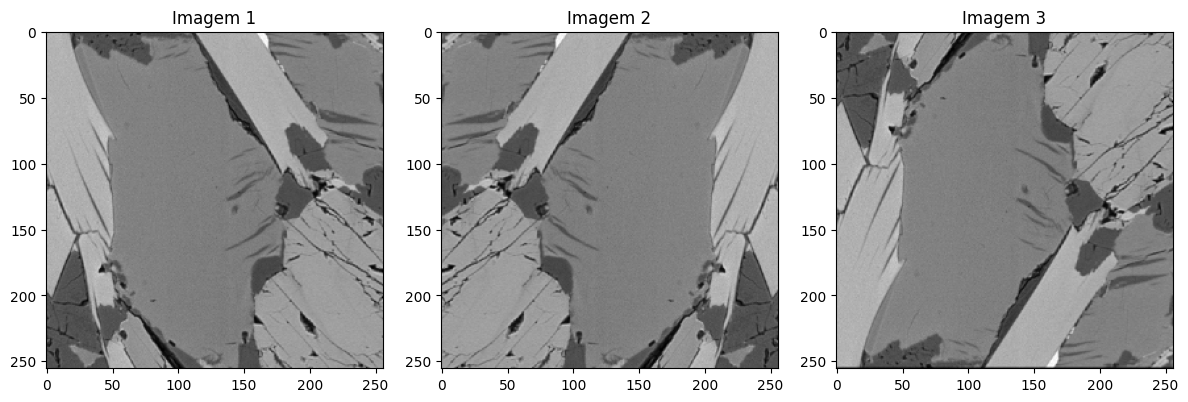

In [ ]:
def exibir_imagens_lado_a_lado(imagem1, imagem2, imagem3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(imagem1, cmap='gray')
    axs[0].set_title('Imagem 1')

    axs[1].imshow(imagem2, cmap='gray')
    axs[1].set_title('Imagem 2')

    axs[2].imshow(imagem3, cmap='gray')
    axs[2].set_title('Imagem 3')

    plt.tight_layout()
    plt.show()

caminho_horiz = '/content/teste/espelho_horizontal.tif'
caminho_vert = '/content/teste/espelho_vertical.tif'

imagem2 = Image.open(caminho_horiz)
imagem3 = Image.open(caminho_vert)

exibir_imagens_lado_a_lado(image, imagem2, imagem3)


In [ ]:
import os
from PIL import Image

def espelhar_e_salvar_imagens_pasta(pasta_entrada, pasta_saida):
    # Cria a pasta de saída se ela não existir
    if not os.path.exists(pasta_saida):
        os.makedirs(pasta_saida)

    for nome_arquivo in os.listdir(pasta_entrada):
        caminho_arquivo = os.path.join(pasta_entrada, nome_arquivo)
        if os.path.isfile(caminho_arquivo):
            try:
                imagem = Image.open(caminho_arquivo)

                imagem_espelhada_horizontal = imagem.transpose(Image.FLIP_LEFT_RIGHT)
                nome_arquivo_horizontal = os.path.splitext(nome_arquivo)[0] + "_H.tif"
                caminho_saida_horizontal = os.path.join(pasta_saida, nome_arquivo_horizontal)
                imagem_espelhada_horizontal.save(caminho_saida_horizontal)
                print(f"Imagem espelhada horizontalmente salva como '{nome_arquivo_horizontal}'")

                imagem_espelhada_vertical = imagem.transpose(Image.FLIP_TOP_BOTTOM)
                nome_arquivo_vertical = os.path.splitext(nome_arquivo)[0] + "_V.tif"
                caminho_saida_vertical = os.path.join(pasta_saida, nome_arquivo_vertical)
                imagem_espelhada_vertical.save(caminho_saida_vertical)
                print(f"Imagem espelhada verticalmente salva como '{nome_arquivo_vertical}'")
            except IOError:
                print(f"Não foi possível processar o arquivo '{caminho_arquivo}'.")

# Exemplo de uso
pasta_entrada = "/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_masks/"
pasta_saida = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Validacao/val_mask/'
espelhar_e_salvar_imagens_pasta(pasta_entrada, pasta_saida)


Imagem espelhada horizontalmente salva como 'AT-Z-01-53_1x1_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-53_1x1_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-53_2x1_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-53_2x1_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-53_1x2_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-53_1x2_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-54_2x1_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-54_2x1_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-53_2x2_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-53_2x2_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-53_1x3_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-53_1x3_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-54_1x2_H.tif'
Imagem espelhada verticalmente salva como 'AT-Z-01-54_1x2_V.tif'
Imagem espelhada horizontalmente salva como 'AT-Z-01-54_1x3_H.tif'
Imagem es

In [ ]:
caminho = '/content/drive/MyDrive/DisciplinaMachineLearning/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_images/'

quantidade_arquivos = len(os.listdir(caminho))
print(quantidade_arquivos)

1008


In [ ]:
import os

pasta = "/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_images/"  # Substitua pelo caminho da pasta que deseja verificar

print(len(os.listdir(pasta)))
for nome_arquivo in os.listdir(pasta):
    if "_V.tif" in nome_arquivo or "_H.tif" in nome_arquivo:
        caminho_arquivo = os.path.join(pasta, nome_arquivo)
        os.remove(caminho_arquivo)
        print(f"O arquivo {nome_arquivo} foi excluído.")

print(len(os.listdir(pasta)))


396
O arquivo AT-Z-01-32_1x1_H.tif foi excluído.
O arquivo AT-Z-01-32_1x1_V.tif foi excluído.
O arquivo AT-Z-01-32_1x2_H.tif foi excluído.
O arquivo AT-Z-01-32_1x2_V.tif foi excluído.
O arquivo AT-Z-01-32_2x1_H.tif foi excluído.
O arquivo AT-Z-01-32_2x1_V.tif foi excluído.
O arquivo AT-Z-01-32_2x2_H.tif foi excluído.
O arquivo AT-Z-01-32_2x2_V.tif foi excluído.
O arquivo AT-Z-01-32_1x3_H.tif foi excluído.
O arquivo AT-Z-01-32_1x3_V.tif foi excluído.
O arquivo AT-Z-01-32_2x3_H.tif foi excluído.
O arquivo AT-Z-01-32_2x3_V.tif foi excluído.
O arquivo AT-Z-02-01_1x1_H.tif foi excluído.
O arquivo AT-Z-02-01_1x1_V.tif foi excluído.
O arquivo AT-Z-02-01_1x2_H.tif foi excluído.
O arquivo AT-Z-02-01_1x2_V.tif foi excluído.
O arquivo AT-Z-02-01_2x1_H.tif foi excluído.
O arquivo AT-Z-02-01_2x1_V.tif foi excluído.
O arquivo AT-Z-02-01_2x2_H.tif foi excluído.
O arquivo AT-Z-02-01_2x2_V.tif foi excluído.
O arquivo AT-Z-02-01_1x3_H.tif foi excluído.
O arquivo AT-Z-02-01_1x3_V.tif foi excluído.
O arqu

In [ ]:
import os
import shutil

# Definir o caminho da pasta de origem e destino
pasta_origem = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_masks2/'
pasta_destino = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/images_horiz_vert/'

# Verificar se a pasta de origem existe
if not os.path.exists(pasta_origem):
    print(f"A pasta de origem '{pasta_origem}' não existe.")
    exit()

# Criar a pasta de destino, se ela não existir
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

# Listar todos os arquivos na pasta de origem
arquivos = os.listdir(pasta_origem)

# Percorrer todos os arquivos
for arquivo in arquivos:
    caminho_arquivo = os.path.join(pasta_origem, arquivo)


    # Verificar se o termo [-5] é 'H' ou 'V'
    if len(arquivo) > 5 and (arquivo[5] == 'H' or arquivo[5] == 'V'):
        # Mover o arquivo para a pasta de destino
        shutil.move(caminho_arquivo, os.path.join(pasta_destino, arquivo))

print("Processo concluído.")


Processo concluído.
